In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !pip install pandas-path

In [3]:
# !pip install xarray

In [4]:
# !pip install xarray-spatial

In [5]:
# !pip install xarray dask netCDF4 bottleneck

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import shutil
import rasterio
import random
from rasterio.plot import show
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from typing import Optional, List

In [4]:
import xarray
import xrspatial.multispectral as ms

In [5]:
PROJECT_DIR = Path.cwd().parent.resolve() / "cloud_cover_competition"
DATA_DIR = PROJECT_DIR / "data"
print(DATA_DIR)

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

/home/ying/cloud_cover_competition/data


In [6]:
BANDS = ["B02", "B03", "B04", "B08"]

In [7]:
train_meta = pd.read_csv(PROJECT_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [8]:
train_meta[["chip_id","location","datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [9]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

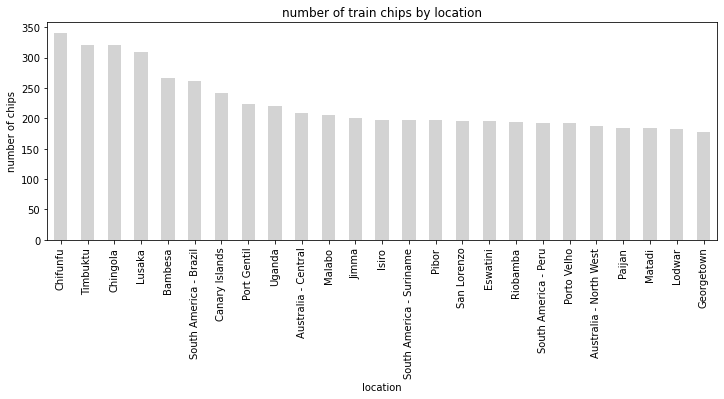

In [10]:
plt.figure(figsize=(12,4))
train_location_counts.head(25).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("location")
plt.ylabel("number of chips")
plt.title("number of train chips by location")
plt.show()

In [11]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])

In [12]:
train_meta["year"] = train_meta.datetime.dt.year

In [13]:
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(columns={"chip_id": "chip_count"})

,chip_count
year,
2018,326
2019,1015
2020,10407


In [14]:
train_meta["datetime"].min(), train_meta[
    "datetime"
].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [15]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


In [16]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()
        
    return df

In [17]:
train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [18]:
train_meta.loc[0, "label_path"]

PosixPath('/home/ying/cloud_cover_competition/data/train_labels/adwp.tif')

In [19]:
example_chip = train_meta[train_meta["chip_id"]=="pbyl"]
display(example_chip)

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
6571,pbyl,Lodwar,2020-09-08 08:09:15+00:00,az://./train_features/pbyl,2020,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [20]:
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

In [21]:
chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

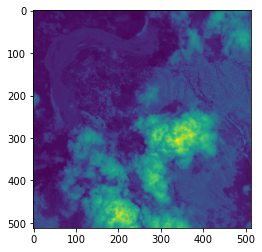

In [22]:
plt.imshow(img_array)

In [23]:
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 35.46935026347422, latitude: 2.9714117132510944


In [24]:
bounds

BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0)

In [25]:
def lat_long_bounds(filepath):
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)
    return crs_transform.transform_bounds(*bounds)

In [26]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long): \n Start: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long): 
 Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


In [27]:
def get_xarray(filepath):
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

In [28]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    return ms.true_color(r=red, g=green, b=blue)

Text(0.5, 1.0, 'True color image for chip ID pbyl')

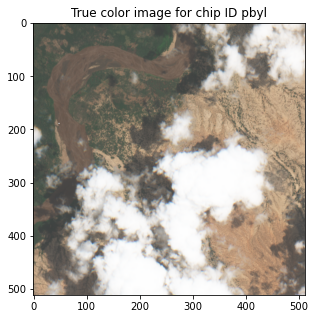

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip ID {example_chip.chip_id}")

In [30]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    chid, location, label = random_chip.chip_id, random_chip.location, random_chip.label_path
    ax[0].imshow(true_color_img(chid))
    ax[0].set_title(f"Chip {chid}\n(Location: {location})")
    label_im = Image.open(label)
    print(np.array(label_im))
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {chid} label")
    plt.tight_layout()
    plt.show()

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


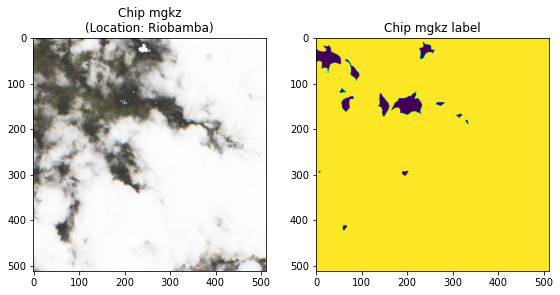

In [31]:
display_random_chip(1)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


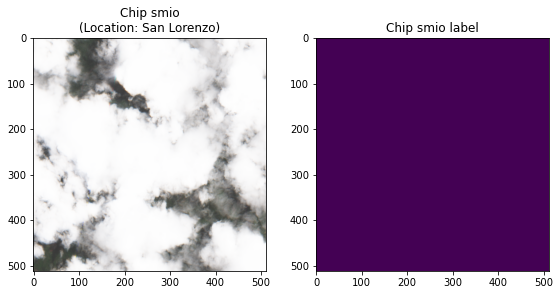

In [32]:
display_random_chip(23)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


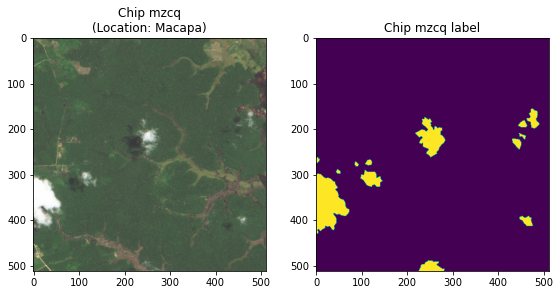

In [33]:
display_random_chip(9)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


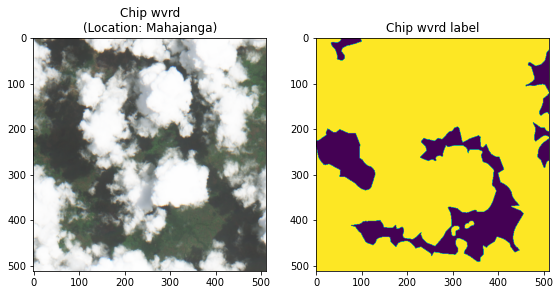

In [34]:
display_random_chip(40)

In [35]:
random.seed(9)

In [36]:
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 10), (7871, 10))

In [37]:
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [61]:
test_chip_ids = random.sample(chip_ids, round(len(val) * .5))
test_mask = train_meta.chip_id.isin(test_chip_ids)
test = train_meta[test_mask].copy().reset_index(drop=True)
test_x = test[feature_cols].copy()
test_y = test[["chip_id","label_path"]].copy()

In [38]:
val_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,aeej,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,aeey,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,aegb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeky,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [39]:
val_y.head()

,chip_id,label_path
0,adwz,/home/ying/cloud_cover_competition/data/train_...
1,aeej,/home/ying/cloud_cover_competition/data/train_...
2,aeey,/home/ying/cloud_cover_competition/data/train_...
3,aegb,/home/ying/cloud_cover_competition/data/train_...
4,aeky,/home/ying/cloud_cover_competition/data/train_...


In [62]:
test_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,aebi,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,aegb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,aesb,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,aesz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aevh,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [63]:
test_y.head()

,chip_id,label_path
0,aebi,/home/ying/cloud_cover_competition/data/train_...
1,aegb,/home/ying/cloud_cover_competition/data/train_...
2,aesb,/home/ying/cloud_cover_competition/data/train_...
3,aesz,/home/ying/cloud_cover_competition/data/train_...
4,aevh,/home/ying/cloud_cover_competition/data/train_...


In [59]:
submission_dir = Path("benchmark_src")
# if submission_dir.exists():
#     shutil.rmtree(submission_dir)

if not submission_dir.exists():
    submission_dir.mkdir(parents=True)

In [40]:
from benchmark_src.cloud_model import CloudModel

In [41]:
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y
)

In [42]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True
)

In [43]:
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

In [44]:
trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [45]:
torch.cuda.is_available()

True

In [46]:
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model=cloud_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.759    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved. New best score: 0.840
Epoch 0, global step 983: iou_epoch reached 0.84010 (best 0.84010), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=0-step=983.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.002 >= min_delta = 0.0. New best score: 0.842
Epoch 1, global step 1967: iou_epoch reached 0.84233 (best 0.84233), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=1-step=1967.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.012 >= min_delta = 0.0. New best score: 0.855
Epoch 2, global step 2951: iou_epoch reached 0.85458 (best 0.85458), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=2-step=2951.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.009 >= min_delta = 0.0. New best score: 0.864
Epoch 3, global step 3935: iou_epoch reached 0.86354 (best 0.86354), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=3-step=3935.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.008 >= min_delta = 0.0. New best score: 0.872
Epoch 4, global step 4919: iou_epoch reached 0.87164 (best 0.87164), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=4-step=4919.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 5903: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.872
Epoch 6, global step 6887: iou_epoch reached 0.87205 (best 0.87205), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=6-step=6887.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 7871: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 8855: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 9839: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 10823: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 11807: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 12791: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 13775: iou_epoch was not in top 1


Validating: 0it [00:00, ?it/s]

Metric iou_epoch improved by 0.000 >= min_delta = 0.0. New best score: 0.872
Epoch 14, global step 14759: iou_epoch reached 0.87243 (best 0.87243), saving model to "/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

In [49]:
checkpoint_file = '/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt'

In [47]:
optimizer = torch.optim.Adam(cloud_model.model.parameters(), lr=cloud_model.learning_rate)

In [66]:
checkpoint = torch.load(checkpoint_file)

In [52]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [55]:
cloud_model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_states'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

<All keys matched successfully>

In [57]:
# cloud_model.state_dict()

In [60]:
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

In [67]:
!tree benchmark_src

/bin/bash: tree: command not found
